# Import

In [1]:
import os, joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model, Model

In [2]:
current = os.getcwd()
os.chdir('../modelEval')

In [3]:
from scripts.evalModel import precision, getPredDist, countDrugsK

In [4]:
os.chdir('../../src/models/')

In [5]:
from fsCDR import fsCDR

In [6]:
os.chdir(current)

# Load Data 

## RNA

In [7]:
trainRNA = pd.read_csv('../../data/processed/RNA_train_cancergenes.csv', index_col=0)
valRNA = pd.read_csv('../../data/processed/RNA_val_cancergenes.csv', index_col=0)
testRNA = pd.read_csv('../../data/processed/RNA_test_cancergenes.csv', index_col=0)
newRNA = pd.read_csv('../../data/processed/RNA_newcancer_cancergenes.csv', index_col=0)

## Drugs

In [8]:
drugs = pd.read_csv('../../data/processed/drug_fingerprints.csv', index_col=0)

## CDR

In [9]:
cdr = pd.read_csv('../../data/processed/drugCellLinePairsData.csv')
cdrFilt = cdr.loc[:, ['DepMap_ID', 'cancer_type', 'name', 'ic50', 'auc', 'lower_limit', 'effectiveCont', 'effective']]
cdrFilt.rename(columns={'DepMap_ID': 'cell_line', 'name': 'drug', 'effective': 'true'}, inplace=True)
cdrFilt.head()

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true
0,ACH-000320,Pancreatic Cancer,floxuridine,0.007879,0.336463,0.105140,6.692422,0
1,ACH-001145,Ovarian Cancer,floxuridine,0.041552,0.485618,0.099077,5.053845,0
2,ACH-000873,Esophageal Cancer,floxuridine,0.097745,0.548483,0.060055,4.697597,0
3,ACH-000855,Esophageal Cancer,floxuridine,0.037349,0.631609,0.390028,4.052632,0
4,ACH-000488,Esophageal Cancer,floxuridine,0.071628,0.598061,0.236216,3.801377,0


# Process data

## Combine RNA

In [10]:
allRNA = pd.concat([trainRNA, valRNA])
allRNA.shape

(300, 463)

# Make result dfs

In [11]:
rows = ['fold0', 'fold1', 'fold2', 'fold3', 'fold4']
cols = ['p1', 'p2', 'p3', 'p4', 'p5', 'p10', 'nWrong', 'nUnique', 'variance']

In [12]:
clTest = pd.DataFrame(index=rows, columns=cols)
clNew = pd.DataFrame(index=rows, columns=cols)

ctTest = pd.DataFrame(index=rows, columns=cols[:5])
ctNew = pd.DataFrame(index=rows, columns=cols[:5])

# Define

## visualization functions

In [13]:
def minMaxNorm(series):
    return (series - series.min()) / (series.max() - series.min())


def vizImportance(series, drugColor='#377eb8', cellColor='#e41a1c', norm=True):
    # process series / importance data
    if norm:
        series = minMaxNorm(series)
    series = series[series > 0.0].sort_values(ascending=False)
    
    # define bar colors
    colors = []
    for idx in series.index:
        if idx.startswith('drug'):
            colors.append(drugColor)
        else:
            colors.append(cellColor)
    
    # plot feature importance
    plt.figure(figsize=(20, 10))
    bars = plt.bar(series.index, series.values, color=colors)
    
    # plot avg importance by feature type
    avgCellImportance = series[series.index.str.startswith('cell')].mean()
    avgCellLine = plt.axhline(avgCellImportance, color=cellColor,
                linestyle='dashed', linewidth=3, label='Avg relative cell line feature importance')
    
    avgDrugImportance = series[series.index.str.startswith('drug')].mean()
    avgDrugLine = plt.axhline(avgDrugImportance, color=drugColor, 
                linestyle='dashed', linewidth=3, label='Avg relative drug feature importance')

    
    # create legend
    drugLeg = mpatches.Patch(color=drugColor, label='Drug features')
    cellLeg = mpatches.Patch(color=cellColor, label='Cell line features')
    plt.legend(handles=[drugLeg, cellLeg, avgDrugLine, avgCellLine], loc=1, fontsize=20)
    
    # format plot
    plt.xlim([0-0.5,len(series)-0.5])
    plt.xticks([])
    plt.ylim([0.0,1.0])
    plt.yticks([0, 1], fontsize=20)
    plt.show()

## paths

In [14]:
rnaPath = '../../models/cellEncoders/'
rnaModel = 'CellLineFewShot_Layers2_Hidden64_DO0-1_AFrelu_LR0-001_DR0-99_DS1000'
rnaPath = os.path.join(rnaPath, rnaModel)

## Func to init and train model

In [15]:
basePath = '../../models/fsCDR/DNN/crossValidation'

In [16]:
# best model: 'Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500'

def getDNN(trainCDR, valCDR, fold):
    # define model path
    modelName = f'Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_{fold}'
    modelPath = os.path.join(basePath, modelName)
    
    # init DNN
    np.random.seed(5)
    dnn = fsCDR(cellLineModelPath=rnaPath, 
                drugModelPath='None', 
                fusionModelPath='None',
                nodeList=[64, 64], 
                activation='relu', 
                dropout=0.1)
    
    trainData = (tf.convert_to_tensor(drugs.loc[list(trainCDR.drug), :], dtype=tf.float32), 
                 tf.convert_to_tensor(allRNA.loc[list(trainCDR.cell_line), :], dtype=tf.float32),
                 tf.convert_to_tensor(trainCDR.true, dtype=tf.float32))
    
    valData = (tf.convert_to_tensor(drugs.loc[list(valCDR.drug), :], dtype=tf.float32), 
               tf.convert_to_tensor(allRNA.loc[list(valCDR.cell_line), :], dtype=tf.float32),
               tf.convert_to_tensor(valCDR.true, dtype=tf.float32))
    
    # fit DNN
    history = dnn.fit(train=trainData, 
                      val=valData, 
                      learningRate=0.01, 
                      decayRate=0.99, 
                      decaySteps=500,
                      earlyStopping=True, 
                      patience=10,
                      minDelta=0.001,
                      batchSize=256, 
                      epochs=250, 
                      saveModel=True, 
                      modelPath=modelPath)
    
    return dnn

# 5-fold CV

## encoder newcancer data

In [17]:
testCDR = cdrFilt[cdrFilt.cell_line.isin(testRNA.index)]

testData = [tf.convert_to_tensor(drugs.loc[list(testCDR.drug), :], dtype=tf.float32), 
            tf.convert_to_tensor(testRNA.loc[list(testCDR.cell_line), :], dtype=tf.float32)]

newCDR = cdrFilt[cdrFilt.cell_line.isin(newRNA.index)]

newData = [tf.convert_to_tensor(drugs.loc[list(newCDR.drug), :], dtype=tf.float32), 
            tf.convert_to_tensor(newRNA.loc[list(newCDR.cell_line), :], dtype=tf.float32)]

## Load folds

In [18]:
foldDF = pd.read_csv('../../data/processed/cellLinesForCV.csv')
foldDF.head()

,fold0,fold1,fold2,fold3,fold4
0,ACH-000741,ACH-000026,ACH-000720,ACH-000566,ACH-000890
1,ACH-000396,ACH-000753,ACH-000018,ACH-000011,ACH-000845
2,ACH-000839,ACH-000973,ACH-000905,ACH-000142,ACH-000875
3,ACH-000273,ACH-000231,ACH-000558,ACH-000756,ACH-000869
4,ACH-000323,ACH-000137,ACH-000469,ACH-000232,ACH-000572


## run

In [27]:
models = {}
np.random.seed(0)
for f in foldDF.columns:
    print(f)
    # get cell lines to use in test fold
    testCellLines = list(foldDF[f])
    trainCellLines = list(foldDF.drop(f, axis=1).to_numpy().reshape(-1))
    
    # split data into test and train sets
    trainCDR = cdrFilt[cdrFilt.cell_line.isin(trainCellLines)].copy()
    valCDR = cdrFilt[cdrFilt.cell_line.isin(testCellLines)].copy()
    
    # get trained model
    dnn = getDNN(trainCDR, valCDR, f)
    
    # Test results (cell line)
    testPreds = testCDR.copy()
    testPreds['pred'] = dnn.predict(testData)
    testPreds.sort_values(by='pred', ascending=False, inplace=True)
    testCount, testWrong = countDrugsK(testPreds)
    clTest.loc[f, :] = precision(testPreds, thresh=0.1, at=1, by='cellLine', getResults=True) +\
                        [len(testWrong), len(testCount), round(testPreds.groupby('drug').pred.var().mean(),4)]
    
    # Test results (cancer)
    ctTest.loc[f, :] = list(precision(testPreds.copy(), thresh=0.1, by='cancer').mean())
    
    # New cancer results
    newPreds = newCDR.copy()
    newPreds['pred'] = dnn.predict(newData)
    newPreds.sort_values(by='pred', ascending=False, inplace=True)
    newCount, newWrong = countDrugsK(newPreds)
    newPrecision = precision(newPreds, thresh=0.1, at=1, by='cellLine', getResults=True)
    clNew.loc[f, :] =  newPrecision +\
                        [len(newWrong), len(newCount), round(newPreds.groupby('drug').pred.var().mean(),4)]
    
    # New cancer results (cancer)
    ctNew.loc[f, :] = list(precision(newPreds.copy(), thresh=0.1, by='cancer').mean())
    
    # Keep model
    models[f] = dnn


# cell line test
clTest.loc['mean', :] = clTest.iloc[:5,:].mean()
clTest.loc['std', :] = clTest.iloc[:5,:].std()
clTest.iloc[:, :6] = clTest.iloc[:, :6].astype(float).round(4)

# cancer test
ctTest.loc['mean', :] = ctTest.iloc[:5,:].mean()
ctTest.loc['std', :] = ctTest.iloc[:5,:].std()
ctTest = ctTest.astype(float).round(4)

# cell line new
clNew.loc['mean', :] = clNew.iloc[:5,:].mean()
clNew.loc['std', :] = clNew.iloc[:5,:].std()
clNew.iloc[:, :6] = clNew.iloc[:, :6].astype(float).round(4)

# cancer new
ctNew.loc['mean', :] = ctNew.iloc[:5,:].mean()
ctNew.loc['std', :] = ctNew.iloc[:5,:].std()
ctNew = ctNew.astype(float).round(4)

fold0
[INFO] loading cell line feature extractor...


/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


[INFO] drug feature extractor not loaded. Using raw features...
[INFO] fusion extractor not loaded. Concatenating drug and cell line features...
[INFO] building CDR model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold0/assets
142/142 - 3s - loss: 0.2503 - val_loss: 0.2054 - 3s/epoch - 25ms/step
Epoch 2/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold0/assets
142/142 - 3s - loss: 0.2047 - val_loss: 0.1856 - 3s/epoch - 23ms/step
Epoch 3/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold0/assets
142/142 - 3s - loss: 0.1980 - val_loss: 0.1821 - 3s/epoch - 23ms/step
Epoch 4/250
INFO:tensorflow:Assets writt

/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


[INFO] drug feature extractor not loaded. Using raw features...
[INFO] fusion extractor not loaded. Concatenating drug and cell line features...
[INFO] building CDR model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold1/assets
146/146 - 4s - loss: 0.2372 - val_loss: 0.1960 - 4s/epoch - 27ms/step
Epoch 2/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold1/assets
146/146 - 3s - loss: 0.1993 - val_loss: 0.1879 - 3s/epoch - 23ms/step
Epoch 3/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold1/assets
146/146 - 3s - loss: 0.1930 - val_loss: 0.1821 - 3s/epoch - 23ms/step
Epoch 4/250
146/146 - 2s - loss: 0.1884 

/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


[INFO] drug feature extractor not loaded. Using raw features...
[INFO] fusion extractor not loaded. Concatenating drug and cell line features...
[INFO] building CDR model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold2/assets
149/149 - 4s - loss: 0.2413 - val_loss: 0.2002 - 4s/epoch - 24ms/step
Epoch 2/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold2/assets
149/149 - 4s - loss: 0.1997 - val_loss: 0.1921 - 4s/epoch - 25ms/step
Epoch 3/250
149/149 - 3s - loss: 0.1958 - val_loss: 0.2059 - 3s/epoch - 17ms/step
Epoch 4/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold2/assets
149/149 - 4s - loss: 0.1973 

/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


[INFO] drug feature extractor not loaded. Using raw features...
[INFO] fusion extractor not loaded. Concatenating drug and cell line features...
[INFO] building CDR model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold3/assets
148/148 - 4s - loss: 0.2428 - val_loss: 0.2015 - 4s/epoch - 27ms/step
Epoch 2/250
148/148 - 3s - loss: 0.1980 - val_loss: 0.2017 - 3s/epoch - 18ms/step
Epoch 3/250
148/148 - 3s - loss: 0.1925 - val_loss: 0.2044 - 3s/epoch - 18ms/step
Epoch 4/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold3/assets
148/148 - 4s - loss: 0.1876 - val_loss: 0.1952 - 4s/epoch - 26ms/step
Epoch 5/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_

/users/PAS1475/lawrencep487/.conda/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: siamese is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


[INFO] drug feature extractor not loaded. Using raw features...
[INFO] fusion extractor not loaded. Concatenating drug and cell line features...
[INFO] building CDR model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold4/assets
145/145 - 4s - loss: 0.2429 - val_loss: 0.2066 - 4s/epoch - 25ms/step
Epoch 2/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold4/assets
145/145 - 3s - loss: 0.1968 - val_loss: 0.2008 - 3s/epoch - 24ms/step
Epoch 3/250
INFO:tensorflow:Assets written to: ../../models/fsCDR/DNN/crossValidation/Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold4/assets
145/145 - 4s - loss: 0.1917 - val_loss: 0.1981 - 4s/epoch - 26ms/step
Epoch 4/250
INFO:tensorflow:Assets writt

# Results

## Test set 

In [28]:
clTest

,p1,p2,p3,p4,p5,p10,nWrong,nUnique,variance
fold0,0.9412,0.9118,0.8954,0.8529,0.8353,0.8359,0,15,0.0001
fold1,0.9412,0.9118,0.8954,0.8775,0.8431,0.8282,0,14,0.0
fold2,0.9412,0.902,0.8758,0.848,0.8314,0.8462,0,14,0.0
fold3,0.9608,0.9216,0.8824,0.8431,0.8314,0.8487,1,16,0.0
fold4,0.9608,0.9216,0.9216,0.8775,0.8353,0.8436,0,15,0.0
mean,0.949,0.9137,0.8941,0.8598,0.8353,0.8405,0.2,14.8,0.00002
std,0.0107,0.0082,0.0175,0.0165,0.0048,0.0084,0.447214,0.83666,0.000045


In [30]:
ctTest

,p1,p2,p3,p4,p5
fold0,0.9306,0.9158,0.9051,0.8618,0.8391
fold1,0.9450,0.9158,0.9051,0.8834,0.8541
fold2,0.9306,0.9126,0.8752,0.8542,0.8395
fold3,0.9728,0.9369,0.8877,0.8507,0.8387
fold4,0.9728,0.9314,0.9327,0.8869,0.8463
mean,0.9503,0.9225,0.9012,0.8674,0.8436
std,0.0213,0.0109,0.0216,0.0167,0.0067


## New cancer set 

In [33]:
clNew

,p1,p2,p3,p4,p5,p10,nWrong,nUnique,variance
fold0,0.9692,0.9308,0.9026,0.8808,0.8585,0.8275,1,16,0.0001
fold1,0.9846,0.9385,0.9026,0.8731,0.8646,0.8235,1,15,0.0
fold2,0.9692,0.9385,0.9026,0.8731,0.8462,0.8196,1,14,0.0001
fold3,0.9692,0.9308,0.9077,0.8769,0.8646,0.8294,2,16,0.0001
fold4,0.9692,0.9385,0.9026,0.8923,0.8615,0.8196,1,14,0.0001
mean,0.9723,0.9354,0.9036,0.8792,0.8591,0.8239,1.2,15.0,0.00008
std,0.0069,0.0042,0.0023,0.008,0.0077,0.0045,0.447214,1.0,0.000045


In [32]:
ctNew

,p1,p2,p3,p4,p5
fold0,0.9723,0.9497,0.9236,0.8801,0.8583
fold1,0.9923,0.9597,0.9236,0.8690,0.8628
fold2,0.9756,0.9545,0.9238,0.8886,0.8428
fold3,0.9846,0.9507,0.9233,0.8791,0.8733
fold4,0.9723,0.9590,0.9241,0.8918,0.8581
mean,0.9794,0.9547,0.9237,0.8817,0.8591
std,0.0088,0.0046,0.0003,0.0090,0.0110


# Save CV results

In [34]:
clTest.to_csv('../../data/results/rawDrugEmbedCellConcatDNN-cellLineTest.csv', index=False)
ctTest.to_csv('../../data/results/rawDrugEmbedCellConcatDNN-cancerTest.csv', index=False)
clNew.to_csv('../../data/results/rawDrugEmbedCellConcatDNN-cellLineNew.csv', index=False)
ctNew.to_csv('../../data/results/rawDrugEmbedCellConcatDNN-cancerNew.csv', index=False)

# Examine preds

In [35]:
newPreds[newPreds.cell_line == 'ACH-000268']

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true,pred
18548,ACH-000268,Bile Duct Cancer,sangivamycin,0.209997,0.146064,0.062506,4.692792,0,0.507351
50315,ACH-000268,Bile Duct Cancer,BGT226,0.131253,0.558484,0.012776,5.927107,0,0.446084
19277,ACH-000268,Bile Duct Cancer,epothilone-d,0.031756,0.435622,0.211304,4.754373,0,0.393060
60530,ACH-000268,Bile Duct Cancer,verubulin,0.006034,0.527347,0.407113,5.894469,0,0.390486
59552,ACH-000268,Bile Duct Cancer,rubitecan,0.022811,0.459721,0.147667,5.315568,0,0.367815
23813,ACH-000268,Bile Duct Cancer,delanzomib,0.070964,0.495877,0.019581,6.053362,0,0.182938
57565,ACH-000268,Bile Duct Cancer,LY2606368,0.107362,0.571670,0.090634,4.236721,0,0.138019
48063,ACH-000268,Bile Duct Cancer,GSK2126458,0.071026,0.505074,0.062650,4.956558,0,0.136104
62112,ACH-000268,Bile Duct Cancer,bardoxolone-methyl,1.495878,0.846023,0.233294,1.472731,0,0.051251
60769,ACH-000268,Bile Duct Cancer,VE-822,0.079767,0.513173,0.029019,5.567548,0,0.049722


In [36]:
newPreds[newPreds.drug == 'sangivamycin']

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true,pred
18600,ACH-000977,Prostate Cancer,sangivamycin,0.073939,0.022443,0.004801,8.756170,1,0.544208
18538,ACH-000748,Bone Cancer,sangivamycin,0.072118,0.050259,0.001295,9.486206,1,0.533980
18535,ACH-000903,Thyroid Cancer,sangivamycin,0.015919,0.025177,0.018044,8.316005,1,0.527110
18526,ACH-000898,Gastric Cancer,sangivamycin,0.048649,0.066583,0.058299,6.130048,0,0.524378
18497,ACH-000456,Thyroid Cancer,sangivamycin,0.071472,0.038773,0.033796,6.645105,0,0.521420
18489,ACH-000391,Bone Cancer,sangivamycin,0.079410,0.028722,0.025635,7.042220,0,0.518906
18547,ACH-000674,Gastric Cancer,sangivamycin,0.079040,0.019859,0.016348,7.716697,1,0.517594
18525,ACH-000516,Bone Cancer,sangivamycin,0.080766,0.059154,0.051846,5.958658,0,0.514603
18505,ACH-000159,Kidney Cancer,sangivamycin,0.092590,0.029910,0.016835,7.309402,1,0.514543
18520,ACH-000411,Kidney Cancer,sangivamycin,0.060894,0.037786,0.021841,7.089327,0,0.513477


# Load best model

In [19]:
modelName = f'Unfused-FewShotCDRRawDrugEmbedCell_NL64_64_DO0-1_AFrelu_LR0-01_DR0-99_DS500_fold1'
modelPath = os.path.join(basePath, modelName)
dnn = load_model(modelPath)

In [20]:
dnn.summary()

Model: "FS-CDR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 463)]        0           []                               
                                                                                                  
 pairEncoder (Functional)       (None, 320)          38016       ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 64)           20544       ['pairEncoder[0][0]']       

## Split into encoder and DNN to enable calc of gradient wrt embedding layer

### Encoder

In [39]:
encoder = dnn.get_layer('pairEncoder')

### DNN

In [40]:
subDNN = Sequential()
subDNN.add(Input(shape=(encoder.outputs[0].shape[1])))
for layer in dnn.layers[3:]:
    subDNN.add(layer)

In [41]:
subDNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                20544     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 24,769
Trainable params: 24,769
Non-trainable params: 0
_________________________________________________________________


# Get test and training data for best fold

In [42]:
f = 'fold1'
testCellLines = list(foldDF[f])
trainCellLines = list(foldDF.drop(f, axis=1).to_numpy().reshape(-1))   

# split data into test and train sets
testCDR = cdrFilt[cdrFilt.cell_line.isin(testCellLines)].copy()
trainCDR = cdrFilt[cdrFilt.cell_line.isin(trainCellLines)].copy()

# get raw RNA + Drug data
testData = [tf.convert_to_tensor(drugs.loc[list(testCDR.drug), :], dtype=tf.float32), 
            tf.convert_to_tensor(allRNA.loc[list(testCDR.cell_line), :], dtype=tf.float32)]

trainData = [tf.convert_to_tensor(drugs.loc[list(trainCDR.drug), :], dtype=tf.float32), 
            tf.convert_to_tensor(allRNA.loc[list(trainCDR.cell_line), :], dtype=tf.float32)]

# Get preds on testset

In [21]:
testCDR['pred'] = dnn(testData)
testCDR.sort_values(by='pred', ascending=False, inplace=True)

<ipython-input-21-456b75539c94>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCDR['pred'] = dnn(testData)
<ipython-input-21-456b75539c94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testCDR.sort_values(by='pred', ascending=False, inplace=True)


In [24]:
testCancerResults = precision(testCDR, thresh=0.1, by='cancer')
testCancerResults.loc['Overall', :] = testCancerResults.mean(axis=0)
round(testCancerResults, 4)

,p1,p2,p3,p4,p5
Bladder Cancer,1.0000,1.0000,1.0000,1.0000,0.9333
Brain Cancer,1.0000,0.8750,0.8333,0.8125,0.7500
Breast Cancer,1.0000,0.8333,0.8889,0.8333,0.8667
Colon/Colorectal Cancer,1.0000,1.0000,0.9167,0.9375,0.8500
Endometrial/Uterine Cancer,1.0000,1.0000,0.8889,0.9167,0.8667
Esophageal Cancer,1.0000,0.8333,0.8889,0.8333,0.7333
Head and Neck Cancer,1.0000,1.0000,1.0000,0.9167,0.9333
Liver Cancer,1.0000,1.0000,1.0000,1.0000,1.0000
Lung Cancer,0.9231,0.8462,0.8974,0.8654,0.8769
Ovarian Cancer,1.0000,1.0000,0.9167,0.9375,0.8000


In [44]:
testCount, testWrong = countDrugsK(testCDR, getPcnt=True)
print(testCount.pcntCorrect.mean())
testCount.sort_values(by='total', ascending=False)

0.4607295975873051


,1,2,3,total,pcntCorrect
dolastatin-10,35,5,0,78,0.487179
romidepsin,5,22,8,69,0.492754
10-hydroxycamptothecin,6,6,24,66,0.454545
echinomycin,1,14,12,52,0.480769
triptolide,5,6,1,24,0.500000
alvespimycin,0,2,6,16,0.500000
maytansinol-isobutyrate,6,0,0,12,0.500000
YM-155,0,0,5,9,0.444444
exatecan-mesylate,1,4,0,8,0.375000
epothilone-b,0,0,2,3,0.333333


In [45]:
len(testCount)

11

In [46]:
testCDR.head(15)

,cell_line,cancer_type,drug,ic50,auc,lower_limit,effectiveCont,true,pred
34453,ACH-000775,Lung Cancer,maytansinol-isobutyrate,0.039415,0.448498,0.004400,8.059934,1,0.997851
37906,ACH-000973,Bladder Cancer,dolastatin-10,0.000934,0.083260,0.034100,10.012988,1,0.997618
37875,ACH-000243,Pancreatic Cancer,dolastatin-10,0.000829,0.081804,0.051486,9.863017,1,0.997429
34408,ACH-000781,Lung Cancer,maytansinol-isobutyrate,0.008707,0.398362,0.007194,9.024114,1,0.997408
37851,ACH-000688,Ovarian Cancer,dolastatin-10,0.000968,0.115783,0.072166,9.365494,1,0.997387
34454,ACH-000277,Breast Cancer,maytansinol-isobutyrate,0.005110,0.301369,0.002355,10.658924,1,0.997377
37688,ACH-000781,Lung Cancer,dolastatin-10,0.002425,0.344008,0.253447,7.257643,0,0.997323
37779,ACH-000730,Skin Cancer,dolastatin-10,0.000658,0.095492,0.065555,9.884760,1,0.997322
37870,ACH-000264,Lung Cancer,dolastatin-10,0.000311,0.046553,0.032803,11.337601,1,0.997298
37810,ACH-000777,Esophageal Cancer,dolastatin-10,0.002069,0.249870,0.143801,7.886745,1,0.997297


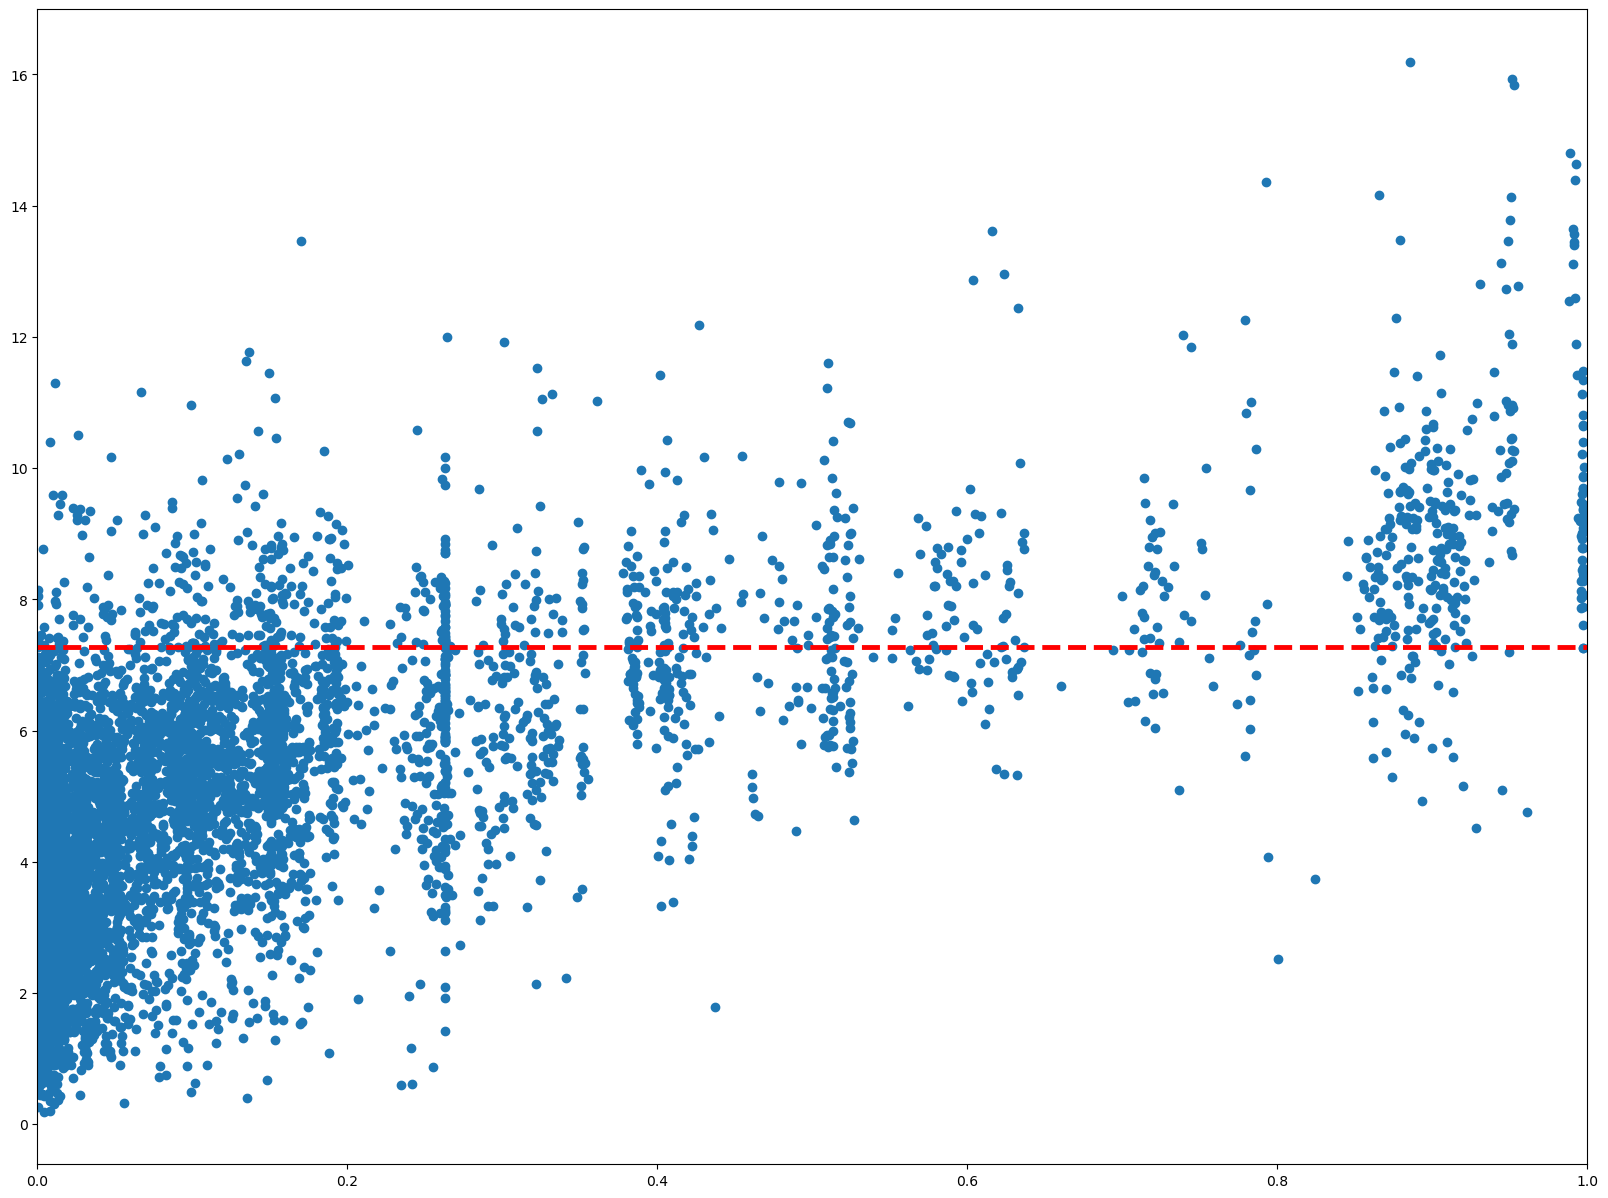

In [47]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=testCDR.effectiveCont)
plt.axhline(7.2734, color='red', linestyle='dashed', linewidth=3.5)
plt.xlim([0,1])
plt.show()

In [48]:
len(set(testCDR[testCDR.pred >= 0.5].drug))

19

In [49]:
len(set(testCDR[(testCDR.pred >= 0.5) & (testCDR.true == 1)].drug))

18

In [50]:
testCDR[testCDR.pred > 0.5].true.sum() / len(testCDR[testCDR.pred > 0.5])

0.756896551724138

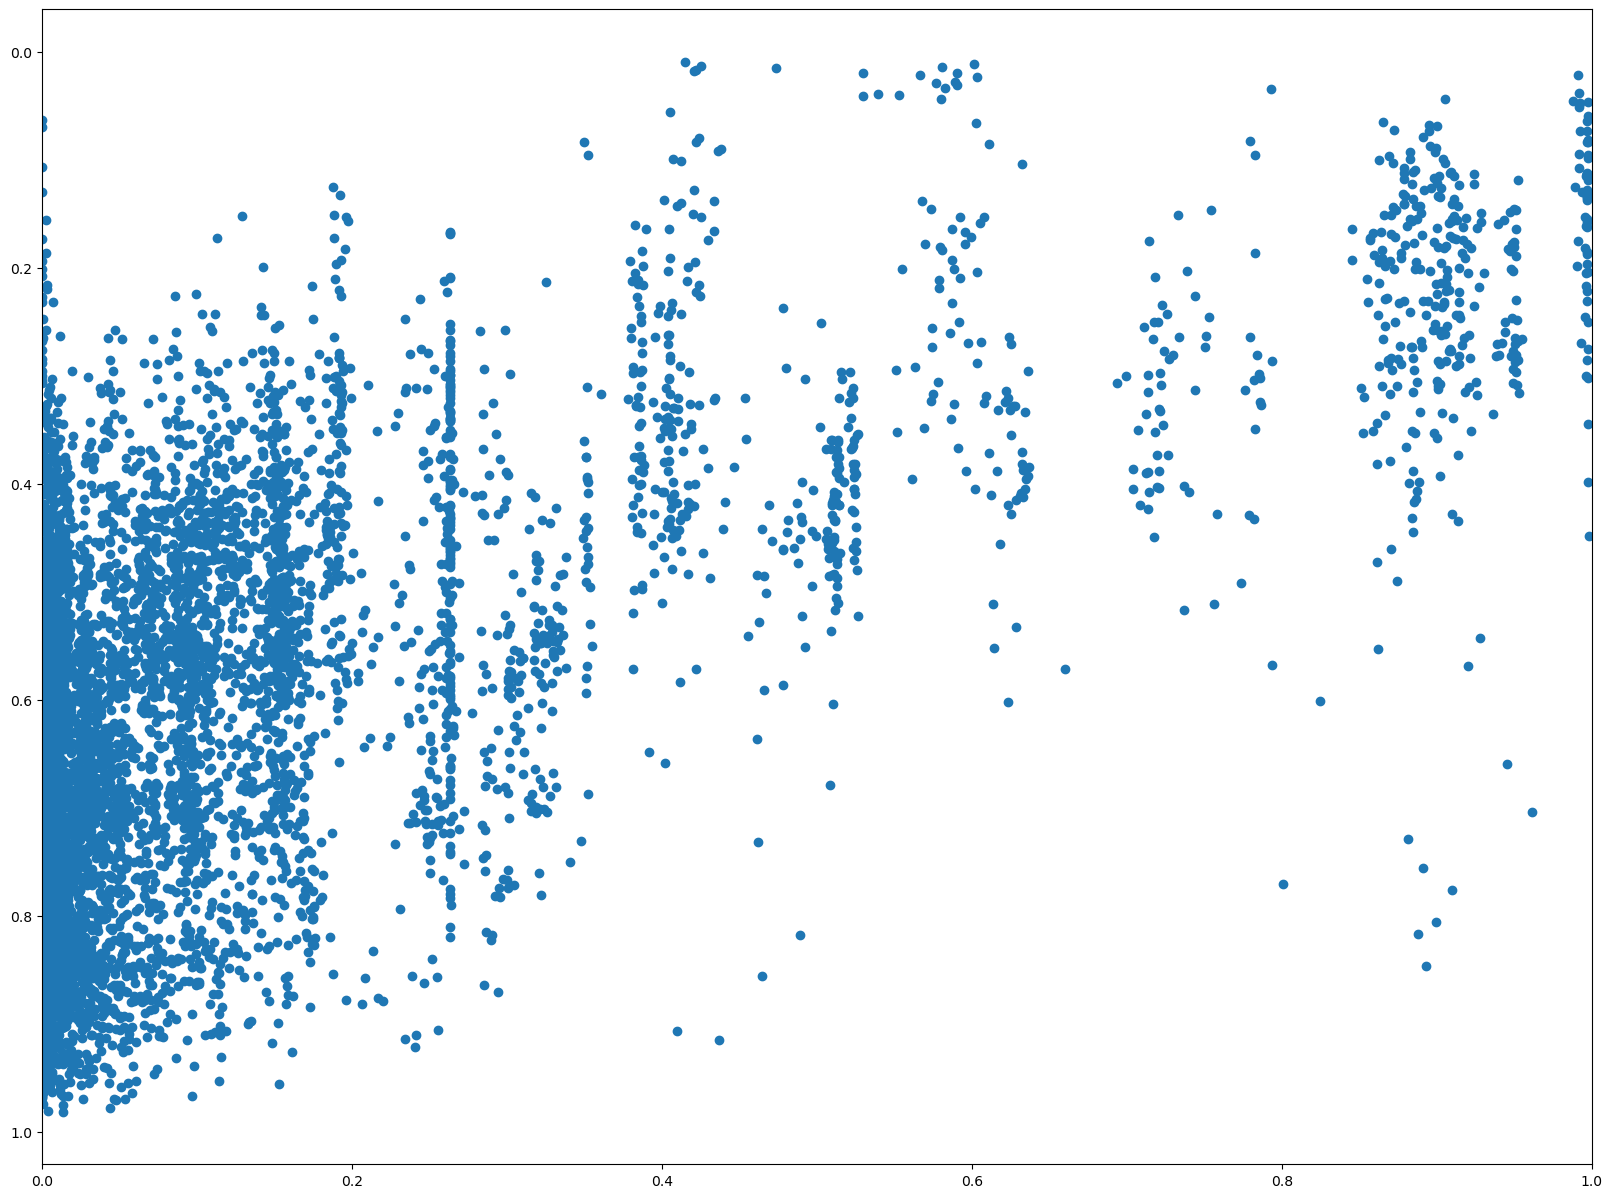

In [51]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=testCDR.auc)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

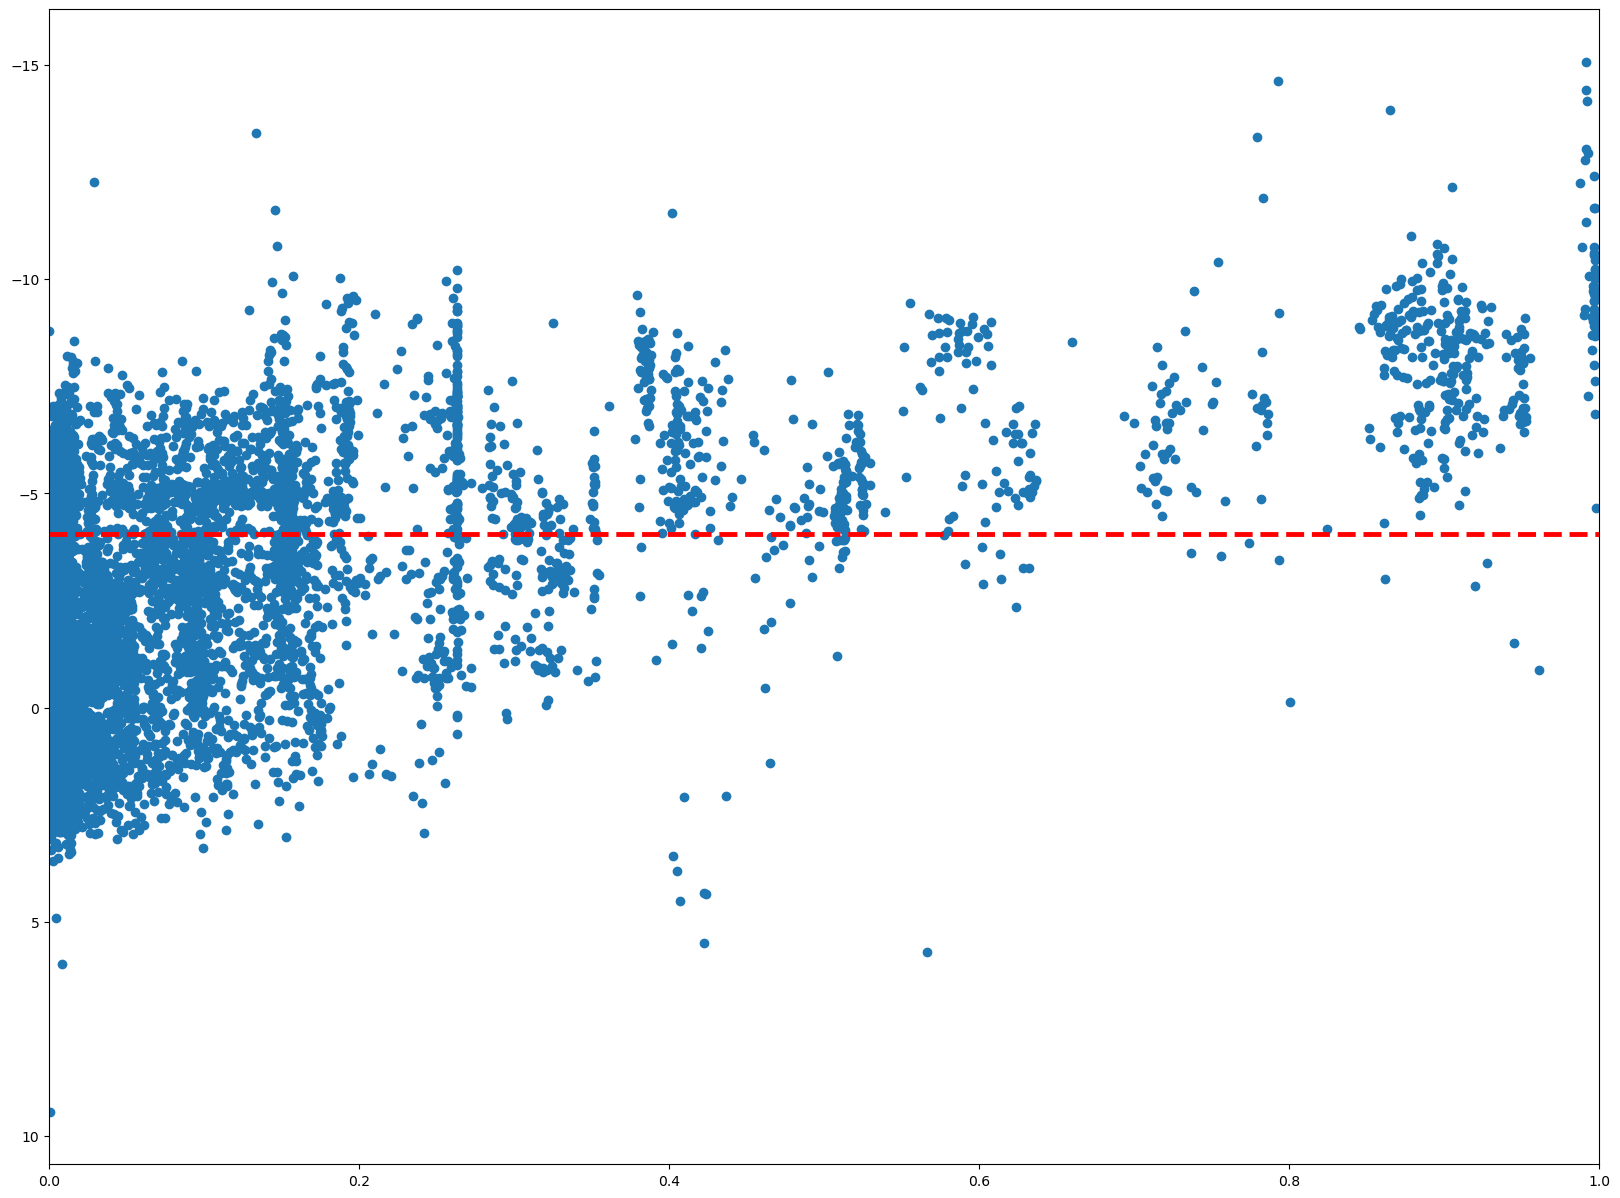

In [52]:
plt.figure(figsize=(20, 15))
plt.scatter(x=testCDR.pred, y=np.log2(testCDR.ic50))
plt.axhline(np.log2(0.06), color='red', linestyle='dashed', linewidth=3.5)
plt.gca().invert_yaxis()
plt.xlim([0,1])
plt.show()

# Get preds on new cancer set

In [22]:
newCDR['pred'] = dnn(newData)
newCDR.sort_values(by='pred', ascending=False, inplace=True)

<ipython-input-22-85c7742b2baa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCDR['pred'] = dnn(newData)
<ipython-input-22-85c7742b2baa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newCDR.sort_values(by='pred', ascending=False, inplace=True)


In [23]:
newCancerResults = precision(newCDR, thresh=0.1, by='cancer')
newCancerResults.loc['Overall', :] = newCancerResults.mean(axis=0)
round(newCancerResults, 4)

,p1,p2,p3,p4,p5
Bile Duct Cancer,1.0000,0.9000,0.8667,0.8500,0.8800
Bone Cancer,1.0000,0.9444,0.9259,0.8889,0.9111
Gallbladder Cancer,1.0000,1.0000,1.0000,0.7500,0.8000
Gastric Cancer,1.0000,1.0000,0.9524,0.9464,0.9143
Kidney Cancer,0.9231,0.8077,0.7949,0.7500,0.7231
Neuroblastoma,1.0000,1.0000,1.0000,0.8333,0.8000
Prostate Cancer,1.0000,1.0000,1.0000,1.0000,0.9000
Rhabdoid,1.0000,1.0000,0.9167,0.9375,0.9000
Sarcoma,0.8333,0.9167,0.9444,0.9167,0.8667
Thyroid Cancer,1.0000,1.0000,0.9583,0.9375,0.8500


In [55]:
len(set(newCDR[newCDR.pred >= 0.5].drug))

20

In [56]:
len(set(newCDR[(newCDR.pred >= 0.5) & (newCDR.true == 1)].drug))

20

In [57]:
newCDR[newCDR.pred > 0.5].true.sum() / len(newCDR[newCDR.pred > 0.5])

0.783359497645212

# Calc gradient of DNN wrt the embedding layer

## Get embdded data

In [58]:
trainEmbed = encoder(trainData)

## Calc gradient

In [59]:
with tf.GradientTape() as tape:
    tape.watch(trainEmbed)
    output = subDNN(trainEmbed)
    
result = output
gradients = tape.gradient(output, trainEmbed)

## Define feature names

In [60]:
ftNames = [f"drugFT{i}" for i in range(256)]
ftNames.extend([f"cellFT{i}" for i in range(64)])

# Plot by avg weight / importance

In [61]:
avgImportance = pd.DataFrame(gradients).mean()
avgImportance.index = ftNames

<ipython-input-13-5c2e99bd4072>:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


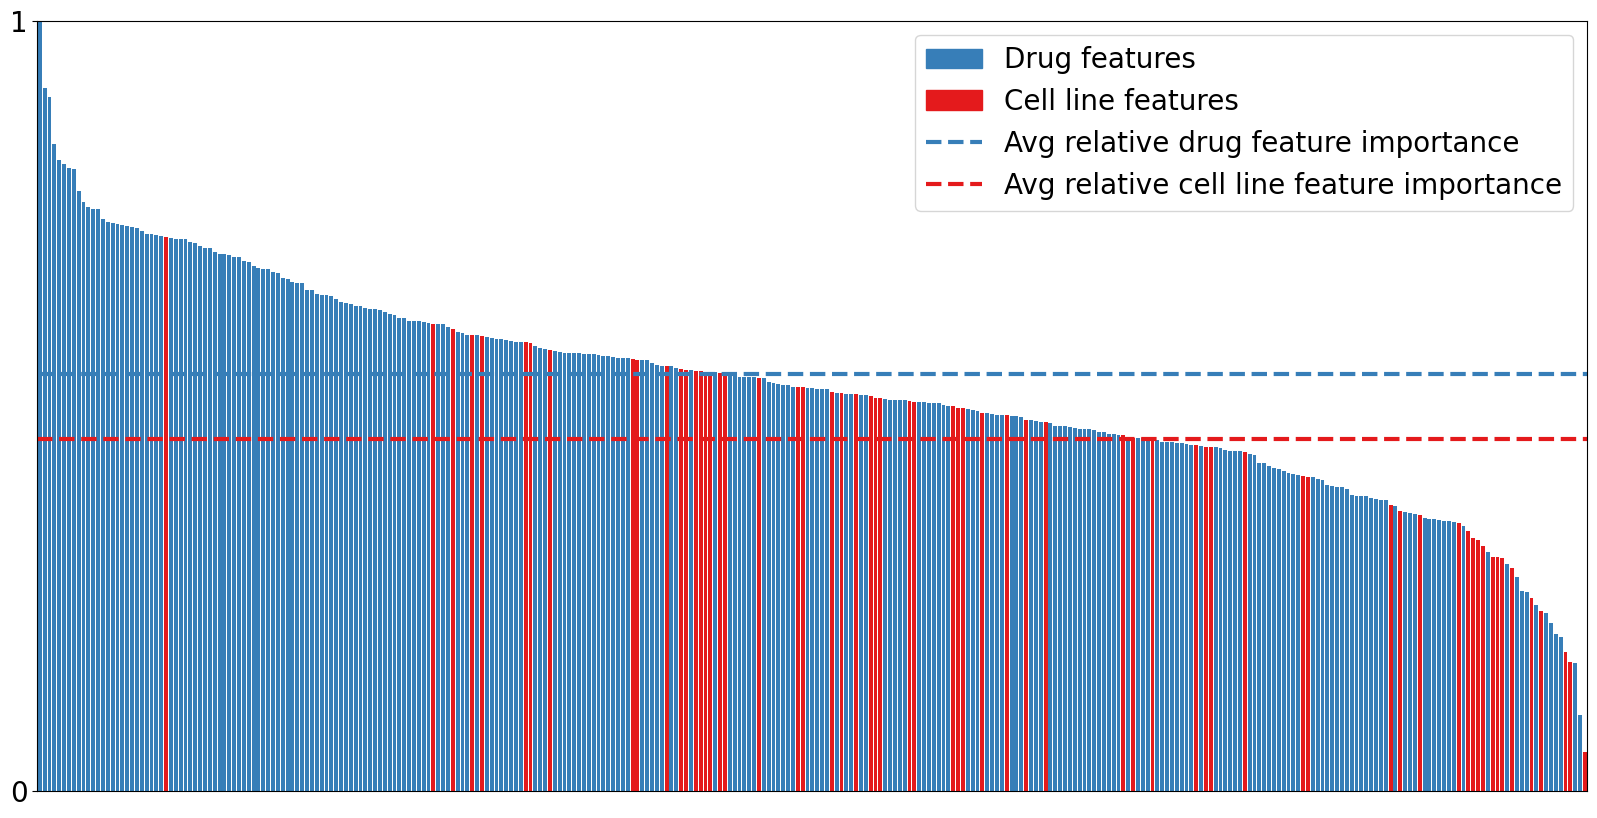

In [62]:
vizImportance(avgImportance)

# Plot by max weight / importance

In [65]:
maxImportance = pd.DataFrame(gradients).max()
maxImportance.index = ftNames

<ipython-input-13-5c2e99bd4072>:40: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


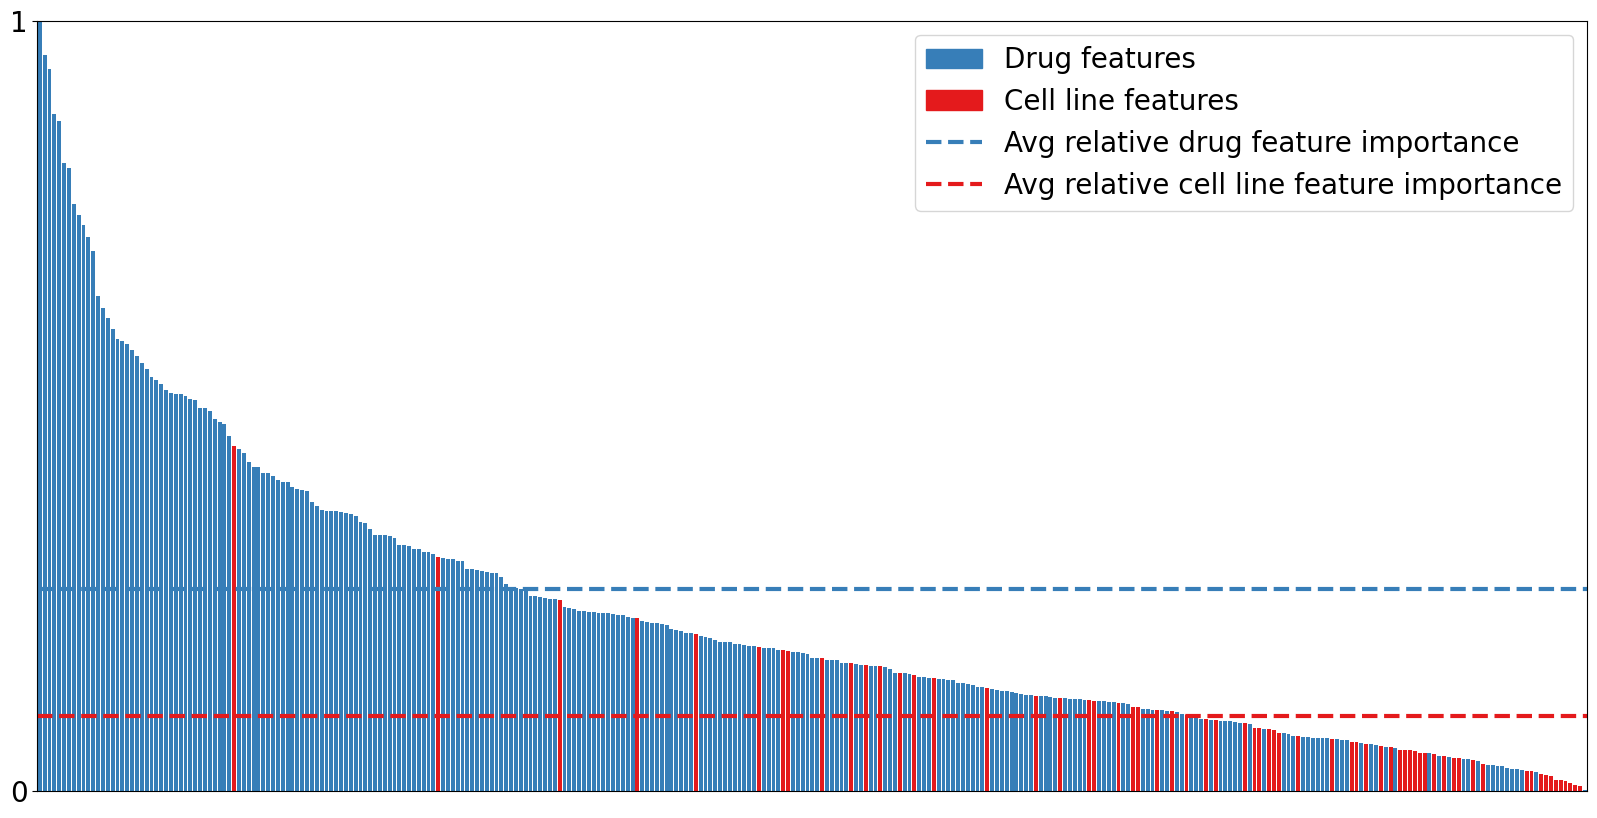

In [66]:
vizImportance(maxImportance)